### Load Libraries

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor

from sklearn.linear_model import LinearRegression

sns.set_theme(style='darkgrid',font_scale=1.3)

### Load Data

In [105]:
df = pd.read_csv('../data/train.csv',index_col=0, parse_dates=True)
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB


In [107]:
# check missing values
df.isna().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### Data Preprocessing

#### Extract time features

In [108]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour
df.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,weekday,hour
datetime,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,5,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,5,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,5,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,5,4


### Exploratory Data Analysis

#### Correlation Analysis of Features

<AxesSubplot:>

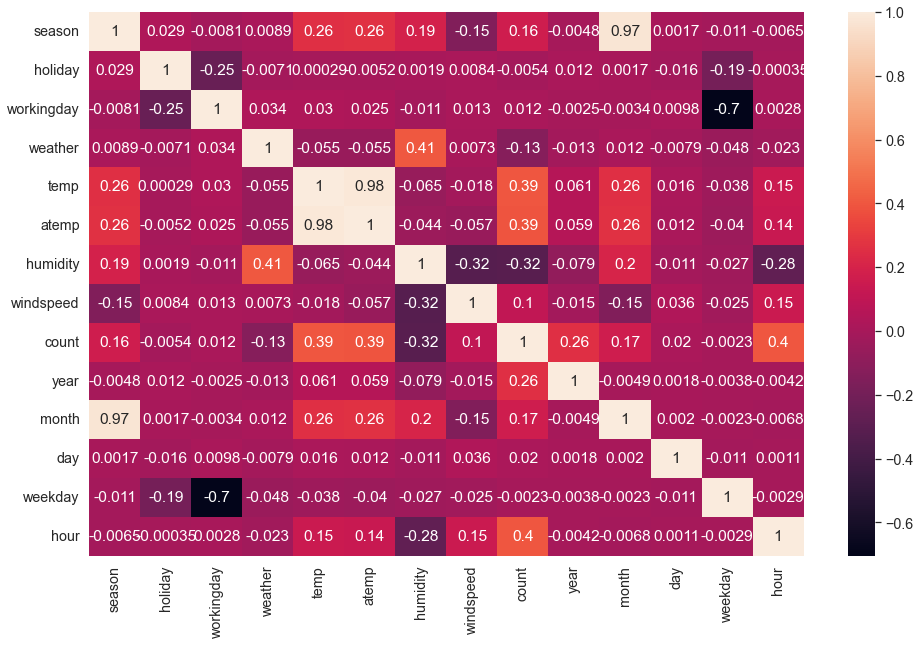

In [109]:
df.head()
plt.figure(figsize=(16,10))
corr = df.drop(['casual','registered'],axis=1).corr()
sns.heatmap(corr, annot=True)

There is high correlation between ```month``` and ```season```, ```weekday``` and ```workingday```, ```temp``` and ```atemp```

Therefore we can drop ``` workingday```, ```season``` and ```atemp```  

In [110]:
# Drop 'workingday', 'season', and 'atemp' 
df.drop(['workingday', 'season', 'atemp'], axis = 1, inplace = True)

#### Analyze Average of Counts Per Time 

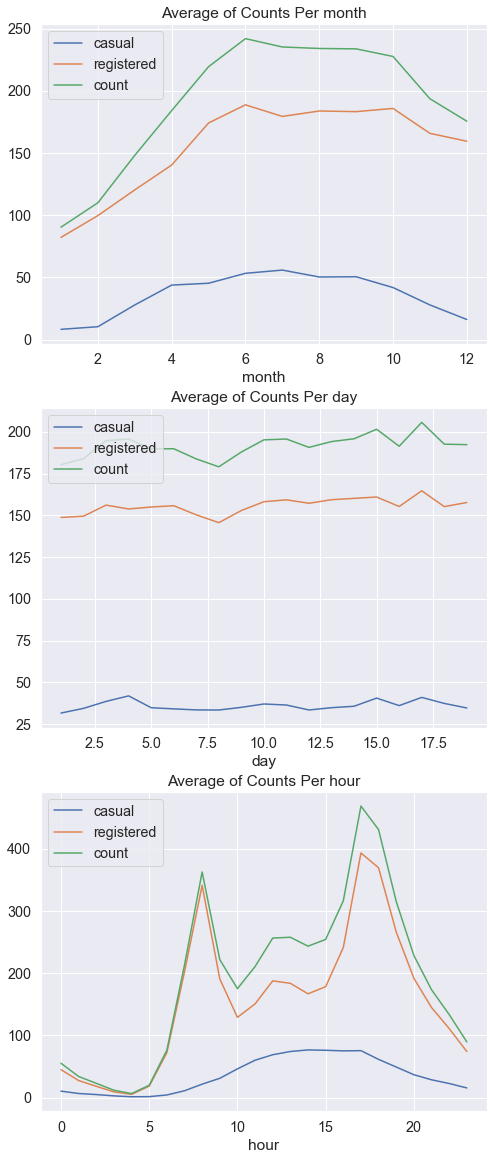

In [121]:
fig, ax = plt.subplots(3, 1, figsize=(8, 20))
ax = ax.flatten() 
features = ['month','day','hour']

for index,feature in enumerate(features):
        
        sns.lineplot(ax=ax[index],x=feature,y='casual',data=df.groupby(feature)['casual'].mean().reset_index(),label ='casual')
        sns.lineplot(ax=ax[index],x=feature,y='registered',data=df.groupby(feature)['registered'].mean().reset_index(),label= 'registered')
        sns.lineplot(ax=ax[index],x=feature,y='count',data=df.groupby(feature)['count'].mean().reset_index(),label = 'count')
        ax[index].legend(loc='upper left')
        ax[index].set_ylabel('')
        ax[index].set_title(f'Average of Counts Per {feature}')

#### Analyze Hourly Trends

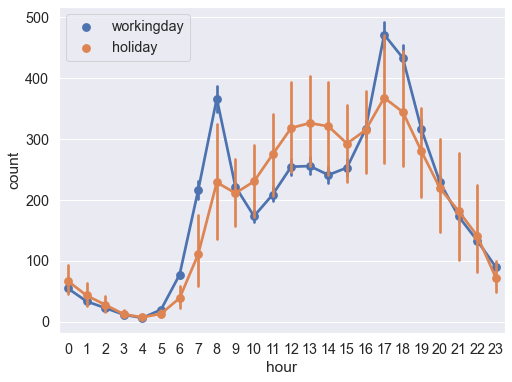

In [143]:
# Hourly trends of count of bikes during weekdays and holdays
fig = plt.figure(figsize=(8,6))
ax = sns.pointplot(data=df, x='hour', y='count', hue='holiday');
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles,['workingday','holiday']);

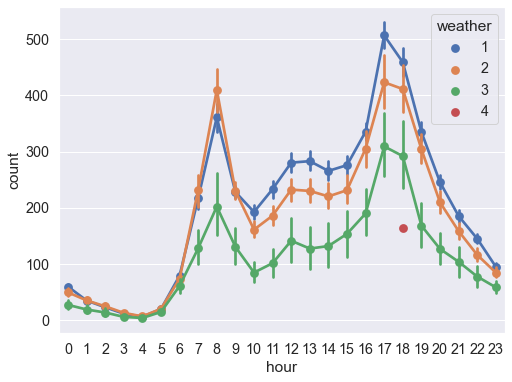

In [144]:
# Hourly trends of count of bikes with differet weather condition (1 = good -> 4 = very bad)
fig = plt.figure(figsize=(8,6))
sns.pointplot(data=df, x="hour", y="count", hue="weather");

#### Analyze Affect of Selected Features on Count

##### Environmental Conditions

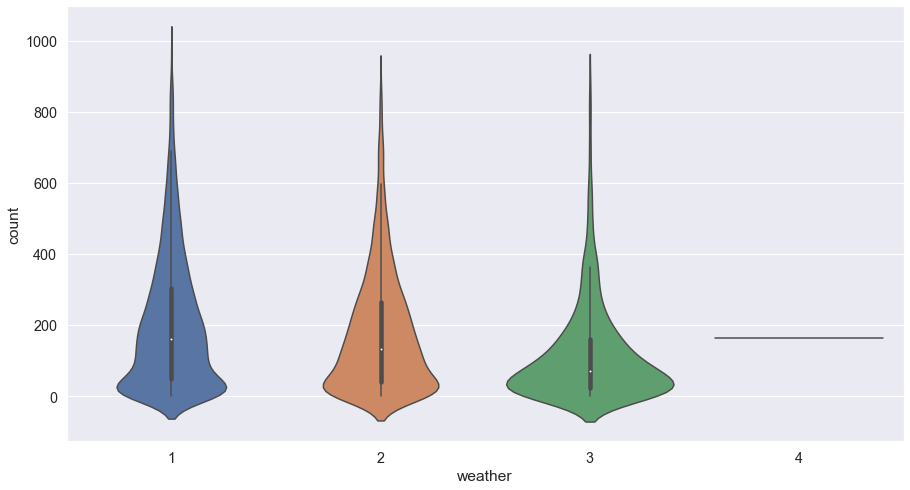

In [124]:
# Counts depending on weather
plt.figure(figsize=(15,8))
ax = sns.violinplot(x=df['weather'].astype(str),y=df['count'], size = 4)
plt.show()

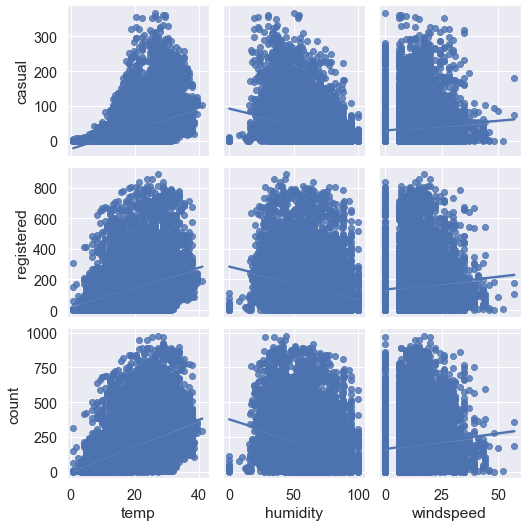

In [125]:
# Counts depending on temp, humidity and, windspeed
sns.pairplot(data = df,
             x_vars = ['temp', 'humidity', 'windspeed'],
             y_vars = ['casual', 'registered', 'count'],
             kind='reg')

People prefer more cycling as the days get hotter and prefere less cycling as the days get wetter

##### Other Features

<AxesSubplot:xlabel='holiday', ylabel='count'>

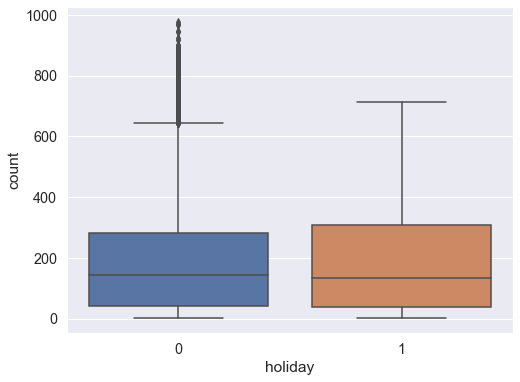

In [130]:
# Counts depending on holiday (holiday = 1)
plt.figure(figsize=(8,6))
sns.boxplot(data = df, x='holiday', y='count')

### Linear regression

In [147]:
# define features and target
X = df.drop(['count','registered','casual'], axis=1)
y = df['count']

In [151]:
# Train-test split of the data
X_train,X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=200)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8708, 10), (2178, 10), (8708,), (2178,))

#### Feature Engineering

Numeric columns should be scaled, categorical columns should be onehot encoded, use of polynomial features

##### Define Pipelines

In [161]:
# Scaling for numeric variables
num_pipe = make_pipeline(
    MinMaxScaler()
)

In [162]:
# One_hot_encoding for categorical variables
cat_pipe = make_pipeline(
    OneHotEncoder(handle_unknown = 'ignore')
)

In [164]:
# Define preprocessor
feature_transform = ColumnTransformer([
    ('do_nothing', 'passthrough', ['holiday']), 
    ('one_hot_encoding', cat_pipe, ['weather','year', 'month', 'day', 'hour']),
    ('scaling', num_pipe, ['temp','humidity', 'windspeed'])
])

#### Create Model

In [174]:
lr = Pipeline([
            ('preprocessor', feature_transform),
            ('poly_features', PolynomialFeatures(degree=2, 
                                                 include_bias=False, 
                                                 interaction_only=False)),
            ('m_lr', LinearRegression())
])

# Do target transformation
lr_t = TransformedTargetRegressor(regressor=lr, func=np.log1p, inverse_func=np.expm1)

In [175]:
lr_t.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessor',
                                                      ColumnTransformer(transformers=[('do_nothing',
                                                                                       'passthrough',
                                                                                       ['holiday']),
                                                                                      ('one_hot_encoding',
                                                                                       Pipeline(steps=[('onehotencoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['weather',
                                                                                        'year',
                                                                                        'month',
                                                                                        'day',
                                                                                        'hour']),
                                                                                      ('scaling',
                                                                                       Pipeline(steps=[('minmaxscaler',
                                                                                                        MinMaxScaler())]),
                                                                                       ['temp',
                                                                                        'humidity',
                                                                                        'windspeed'])])),
                                                     ('poly_features',
                                                      PolynomialFeatures(include_bias=False)),
                                                     ('m_lr',
                                                      LinearRegression())]))

In [180]:
r2_train = round(lr_t.score(X_train, y_train), 2)
print(f'R2 for train dataset: {r2_train}')

R2 for train dataset: 0.79


In [179]:
r2_test = round(lr_t.score(X_test, y_test), 2)
print(f'R2 for test dataset: {r2_test}')

R2 for test dataset: 0.71


In [182]:
y

datetime
2011-01-01 00:00:00     16
2011-01-01 01:00:00     40
2011-01-01 02:00:00     32
2011-01-01 03:00:00     13
2011-01-01 04:00:00      1
                      ... 
2012-12-19 19:00:00    336
2012-12-19 20:00:00    241
2012-12-19 21:00:00    168
2012-12-19 22:00:00    129
2012-12-19 23:00:00     88
Name: count, Length: 10886, dtype: int64